# Solve Household's Problem

This file solves the for the household's (consumption) policy function in the steady state using the endogenous grid point method.

In [1]:
using QuantEcon
using Plots
using DataFrames
import PyPlot

## Calibration

All parameter values are from Table 1 in MNS, except for ```Rbar``` (steady state gross interest rate), which is from MNS's ```initparam.m``` file.

In [2]:
β     = 0.986;
Rbar  = 1.005;
γ     = 2;
μ     = 1.2;
ψ     = 2;
Wbar  = 1/μ; #steady state wage

MNS assume that only rich households (i.e. those with high productivity) pay tax (I specify the productivity grid below).

In [3]:
function tax(x)
    if x==z_grid[3]
        return 1
    else return 0
    end
end

tax (generic function with 1 method)

### Markov chain for idisyncratic productivity

Following MNS, I compute the three-point Markov chain using Rouwenhort's method (this corresponds to MNS's baseline calibration).

In [4]:
MC = rouwenhorst(3, 0.96566, sqrt(0.01695/(1-0.96566^2)), 0);

Note that the transition matrix is stored in ```MC.p``` and the state values are stored in ```MC.state_values```. However, it looks like the state values that the above function spits out are different to the ones the MNS get in Matlab. Accordingly, I will take the state values from MNS's code, to give me the best chance of getting some results that match theirs.

### Create grids for productivity and bond holdings

In [5]:
#z_grid = exp.(MC.state_values); # Very different to MNS's grid, so use theirs.
z_grid  = [0.49229735012925,1,2.03129267248230]; #MNS z_grid

Below I create the grid of bond holdings. There are currently important differences between my grid below and MNS's. MNS use a `logspace' function in Matlab to get more grid points at lower levels of bond holdings (because the policy function has more curvature at lower asset values). I use linspace, so that grid points are evenly space; bear this in mind.

In [6]:
b_min  = 0;
b_max  = 75;
b_grid = collect(linspace(b_min,b_max,200));

## Endogenous grid function

This function updates the guess of the policy function (for a given set of prices) using the endogenous grid method (EGM). The function should be read in conjunction with my TeX notes and draws heavily from the QuantEcon lecture on EGM. I've currently implemented the iteratation with a linear interpolation, rather than MNS's cubic spline interpolation; I should be able incorporate the latter later on.

In [7]:
function egm(G::AbstractArray,
             b_grid::AbstractArray,
             z_grid::AbstractArray,
             P::AbstractArray,
             β::Real,
             γ::Real,
             ψ::Real,
             R::Real,
             W::Real,
             D::Real,
             τ::Real)
   
    # Allocate memory for value of today's consumption on endogenous grid points,...
    # and the endogenous grid itself,...
    # and the updated guess of the policy function for each state pair.
    c      = zeros(length(z_grid),length(b_grid))
    b_eg   = zeros(length(z_grid),length(b_grid))
    KG     = zeros(length(z_grid),length(b_grid))
    
    # Compute today's optimal consumption using Euler equation
    for (i, z) in enumerate(z_grid)
        for (j,b) in enumerate(b_grid)
            c[i,j] = (β*R*P[i,:]'*(G[:,j].^(-γ)))^(-1/γ)
        end
    end

    # Compute endogenous bond grid using the budget constraint
    for (i,z) in enumerate(z_grid)
        for(j,b) in enumerate(b_grid)
            b_eg[i,j] = c[i,j] + b_grid[j]/R - c[i,j]^(-γ/ψ)*(W*z_grid[i])^(1+1/ψ) - D + τ*tax(z_grid[i])
        end
    end
    
    # Compute today's optimal consumption for agents with binding constraint
    for (i,z) in enumerate(z_grid)
        for(j,b) in enumerate(b_grid)
            
            if b_grid[j] <= b_eg[i,1]
                c[i,j] = (b_grid[j]+D-τ*tax(z_grid[i])+sqrt((b_grid[j]+D-τ*tax(z_grid[i]))^2+4*(W*z_grid[i])^(1+1/ψ)))/2
            else
                c[i,j] = c[i,j]
            end
        end
    end
    
    
    # Interpolate the updated guess [NEED TO CHANGE THIS TO CUBIC SPLINE!]
    for (i,z) in enumerate(z_grid)
        KG_f      = LinInterp(b_eg[i,:],c[i,:])
        KG[i,:]   = KG_f.(b_grid)'
    end
    
    return KG

end

egm (generic function with 1 method)

## Compute initial guess of the policy function

To compute the initial guess of the policy function I need to solve equation (4) in my TeX notes. With the calibrated parameters, this is just a quadratic equation, so I can solve it by hand. Note that I write a function to compute the initial guess, which takes dividends as an input. This is because I'll need to solve for the steady state level of dividends (which is a function of steady state consumption).

In [8]:
function G_init(D::Real,τ::Real)

    G0   = zeros(length(z_grid),length(b_grid));

    for (i,z) in enumerate(z_grid)
            for(j,b) in enumerate(b_grid)
                G0[i,j] = (b_grid[j]+D-τ*tax(z_grid[i])+sqrt((b_grid[j]+D-τ*tax(z_grid[i]))^2+4*(Wbar*z_grid[i])^(1+1/ψ)))/2
            end
    end
    
    return G0
end

G_init (generic function with 1 method)

## Policy function iteration

Next, I write a function that takes an initial guess of the policy function, and iterates until convergence.

In [9]:
function get_policy(G0, D, τ, tol=1e-8, maxiter=1000, err=1, i=0)
    G       = G0    # Initial guess

    while i<=maxiter && err > tol

        Gnew = egm(G,b_grid,z_grid,MC.p,β,γ,ψ,Rbar,Wbar,D,τ)

        err  = maximum(abs, Gnew - G)
        G    = Gnew

        i    = i+1
    end
return G

end

get_policy (generic function with 5 methods)

## Simulate distribution of bond holdings

In order to compute aggregate consumption (and hence output and dividends) in the steady state, I need to know the distribtution of bond holdings. To simulate the steady state distribution of bond holdings I first draw a very long vector of productivity draws using the Markov chain. I then pick an initial value for bond holdings. Then I use the policy function to compute next period's bond holdings, and so on. This gives me a level of bond holdings associated with each productivity draw. Then, for each level of productivity, I simply compute a histogram of the bond holdings. Accordingly, I end up with a histogram of bond holdings for each level of productivity. The idea is that if my vector of draws is long enough, this should be the steady state distribution.

First I write a function that creates a vector of idiosyncractic productivity draws of a specified length. (This function draws on the QuantEcon lecture on Finite Markov Chains: <https://lectures.quantecon.org/jl/finite_markov.html#simulation>).

In [10]:
function mc_sample_path(P, init=2, sample_size=1000)
    X = Array{Int64}(sample_size) # allocate memory
    Z = zeros(length(X))
    
    X[1] = init
    
    # === convert each row of P into a distribution === #
    n = size(P)[1]
    P_dist = [DiscreteRV(vec(P[i,:])) for i in 1:n]

    # === generate the sample path for the state (i.e. X \in {1,2,3}) === #
    for t in 1:(sample_size - 1)
        X[t+1] = rand(P_dist[X[t]])
    end
    
    # === get the z associated with each value of the state === #
    for t in 1:(sample_size)
        if X[t]==1
            Z[t]=z_grid[1]
        elseif X[t]==2
            Z[t]=z_grid[2]
        else
            Z[t]=z_grid[3]
        end
    end
    
    return Z
end

mc_sample_path (generic function with 3 methods)

Let's go ahead and simulate those states!

In [11]:
Z=mc_sample_path(MC.p,2,1000000);

Next, I need to write a function that computes the level of bond holdings associated with each individual z-draw using the policy function and budget constraint (given an initial level of bond holdings). Currently, my function isn't very slick. First, I need to back back out the actual optimal policy *functions* for each level of productivity from the ${G}$ matrix (which is clearly inefficient because I compute, but don't store, these when I run my EGM function above!). Then I construct the bond holdings using the policy functions. There are two reasons for this slopiness: (1) I need the actual policy functions because for any $(z_t,b_t)$ pair, using the budget constraint may give a level of bond holdings that doesn't correspond to a point in my bond grid; (2) I can't work out how to properly store the (three, one for each $z$) policy functions in my EGM function above!

Ideas: maybe I could actually compute a two-dimensional function in the interpolation step of my EGM function, rather than a separate function for each $z$?

In [12]:
function get_bonds(Z,G::AbstractArray,D::Real,τ::Real,c1,c2,c3,init=b_grid[1])
    B = zeros(length(Z)) #allocate memory
    
    # This is what c1,c2,c3 will be!
    #c1 = LinInterp(b_grid,G[1,:]); 
    #c2 = LinInterp(b_grid,G[2,:]);
    #c3 = LinInterp(b_grid,G[3,:]);
    
    B[1] = init
    
    for t in 1:(length(B)-1)
        
        if Z[t]==z_grid[1]
            B[t+1]=Rbar*(B[t]+(Wbar*Z[t])^(1+1/ψ)*c1(B[t])^(-γ/ψ)-c1(B[t])+D-τ*tax(z_grid[1]))
        elseif Z[t]==z_grid[2]
            B[t+1]=Rbar*(B[t]+(Wbar*Z[t])^(1+1/ψ)*c2(B[t])^(-γ/ψ)-c2(B[t])+D-τ*tax(z_grid[2]))
        else
            B[t+1]=Rbar*(B[t]+(Wbar*Z[t])^(1+1/ψ)*c3(B[t])^(-γ/ψ)-c3(B[t])+D-τ*tax(z_grid[3]))
        end 
    end
    
    return B
end

get_bonds (generic function with 2 methods)

Almost there. Next I write a simple function that computes aggregate consumption. I simply evaluate the policy function for each $(z,b)$ pair in my long vector; then since there is a unit mass of agents, the mean consumption level is aggregate consumption.

In [13]:
function get_C(B,c1,c2,c3)

C = zeros(length(B)) #allocate memory

    for t in 1:(length(C))

            if Z[t]==z_grid[1]
                C[t]=c1(B[t])
            elseif Z[t]==z_grid[2]
                C[t]=c2(B[t])
            else
                C[t]=c3(B[t])
            end 
    end
    
    return C
end

get_C (generic function with 1 method)

## Solve for steady state

Finally, I write a loop that puts all of the above functions together to solve for steady state. The iterative algorithm proceeds as follows:

1. Guess an initial level of dividends and taxes, $X^0 = [D^0=0, \tau^0=0]$.
2. Using this guess and other steady state prices, compute the HH's policy function.
3. Simulate the distribution of bond holdings, using the policy function.
4. Compute aggregate consumption, $\bar C^0$.
5. Compute the implied level of dividends $\tilde{D}^0 = \bar{C}^0\times(1-\bar{W})$.
6. Compute the implied level of taxes $\tilde{\tau}^0 = 4 \times 1.4\times4\times\bar C^0 \times (\bar{R} -1)/\bar{R}$. Let $\tilde{X}^0 = [\tilde{D}^0,\tilde{\tau}^0]$.
7. Update the guess: $X^1 = \omega  \tilde{X}^0 + (1-\omega)X^0$. I set $\omega=0.5$.
8. Iterate until convergence: $X^n=X^{n-1}$.

In [14]:
#function solve_ss(D=0,tol=1e-8,maxiter=1000,err=1,i=0)

D       = 0    # Initial guess
τ       = 0
tol     = 1e-8   
maxiter = 1000
err     = 1
i       = 0


    while i<=maxiter && err > tol

        global G, C, D, B, τ             # Ensures the loop spits out these things (cf. local)        
    
        X    = [D,τ]
        
        G0   = G_init(D,τ)               # Compute initial guess of policy fn

        G    = get_policy(G0,D,τ)        # Compute policy function

        c1 = LinInterp(b_grid,G[1,:])    # optimal policy *function* for low productivity
        c2 = LinInterp(b_grid,G[2,:])
        c3 = LinInterp(b_grid,G[3,:])

        B  = get_bonds(Z,G,D,τ,c1,c2,c3) # Simulate distribution of bonds

        C  = get_C(B,c1,c2,c3)           # Get consumption distribution

        Dnew = mean(C)*(1-Wbar)          # Compute prelim updated guess of divs
    
        τnew = 4*1.4*4*mean(C)*(Rbar-1)/Rbar # Compute prelim updated guess of τ

        Xnew = [Dnew,τnew]
    
        err  = maximum(abs, Xnew - X)  # Compute error

        D    = 0.5*Dnew + 0.5*D        # Update guess of dividends
        τ    = 0.5*τnew + 0.5*τ         # Update guess of τ

        i    = i+1
    end
#end

In [16]:
#@time solve_ss()

Solved. Convergence takes about 25-30 iterations, and about 30-40 seconds. The steady state policy function is stored in $G$; consumption distribution is $C$; and this distribution of bond holdings is given by the vectors $(Z,B)$.

## Some plots and analysis

First, I plot the steady state policy function for different levels of idiosyncratic productivity. The results are nice: consumption is increasing in wealth, and productivty levels. As MNS note, there is more curvature on the policy function at lower asset levels. Recall that I've implemented the EGM method using an evenly spaced bond grid, and a linear interpolation. This plot is decent evidence why we might want more grid points at lower bond levels.

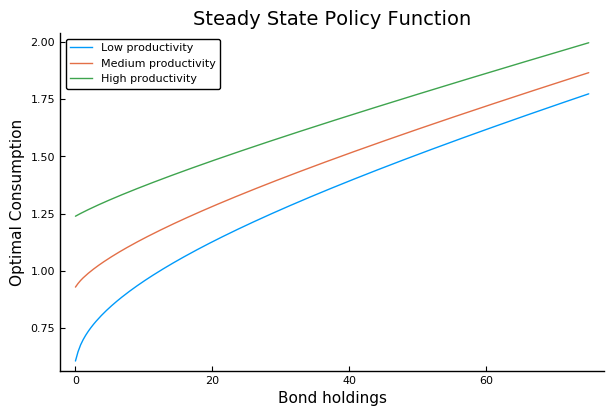

In [67]:
pyplot()
plot(b_grid, G[1, :], label="Low productivity",grid=false)
plot!(b_grid, G[2, :], label="Medium productivity")
plot!(b_grid, G[3, :], label="High productivity")
plot!(xlabel="Bond holdings", ylabel="Optimal Consumption")
plot!(title="Steady State Policy Function")
savefig("/Users/Anirudh/Desktop/GitHub/PhD_Coursework/ECON611/Replication/TeX/pol_fn_C.pdf")

Next, I plot the law of motion for asset holdings for each level of productivity. To do so, I first need to back out next period's bond holdings for each state pair using the budget constraint (which I can do because I know what the optimal consumption levels are for each state pair!). Next period's bond holdings are given by

$$ b_{t+1} = \bar{R}[b+(\bar{W}z)^{1+1/\psi}c^{-\gamma/\psi}+\bar{D}-c]$$

In [64]:
b_next   = zeros(length(z_grid),length(b_grid));

for (i,z) in enumerate(z_grid)
        for(j,b) in enumerate(b_grid)
            b_next[i,j] = Rbar*(b_grid[j]+(Wbar*z_grid[i])^(1+1/ψ)*G[i,j]^(-γ/ψ)+D-G[i,j])
        end
end

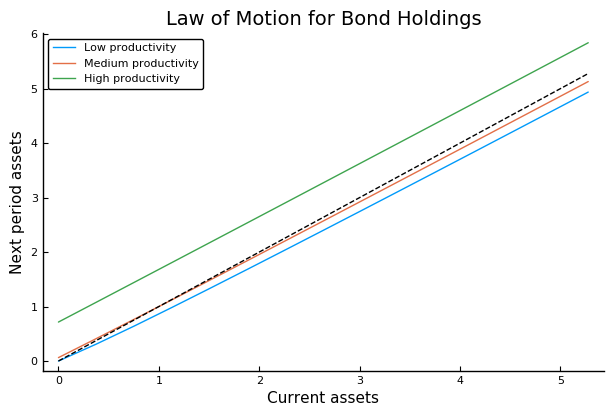

In [66]:
plot(b_grid[1:15], b_next[1,1:15], label="Low productivity", grid=false)
plot!(b_grid[1:15], b_next[2,1:15], label="Medium productivity")
plot!(b_grid[1:15], b_next[3,1:15], label="High productivity")
plot!(b_grid[1:15], b_grid[1:15], linestyle=:dash, color="black", label="")
plot!(xlabel="Current assets", ylabel="Next period assets")
plot!(title="Law of Motion for Bond Holdings")
savefig("/Users/Anirudh/Desktop/GitHub/PhD_Coursework/ECON611/Replication/TeX/pol_fn_B.pdf")

First, note that I only plotted the law of motion for the first 15 grid points; otherwise the lines are very hard to distinguish from one another. Some results worth noting. Agents with a high productivity draw save a lot -- this is the precautionary savings motive at work.

Next, let's look at the steady state distribution of bond holdings.

In [15]:
# Combine Z and B into data frame
df = DataFrame(Z=Z,B=B);

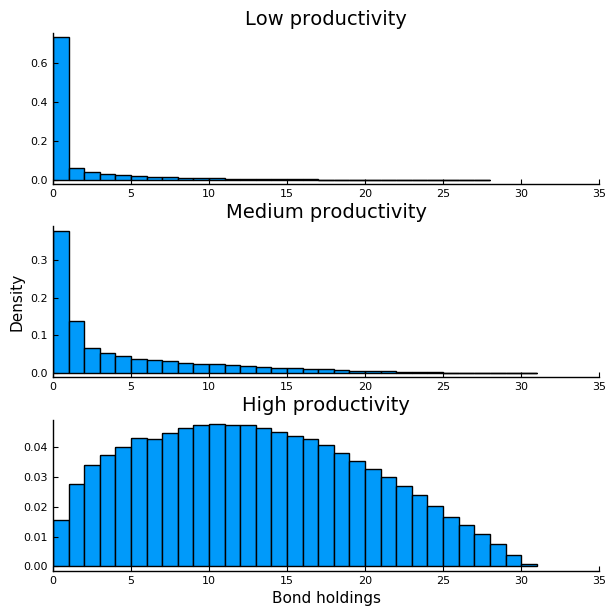

In [73]:
#Make individual histograms for each productivity level
h1 = histogram(df[df[:Z].==z_grid[1],:][2],bins=50,normalized=true,title="Low productivity");
h2 = histogram(df[df[:Z].==z_grid[2],:][2],bins=50,normalized=true,title="Medium productivity",ylabel="Density");
h3 = histogram(df[df[:Z].==z_grid[3],:][2],bins=50,normalized=true,title="High productivity",xlabel="Bond holdings");

# Combine into single plot
p1 = plot(h1,h2,h3,layout=(3,1),legend = false, fmt= :png, size=(600,600),grid=false)
plot!(xlims=(0,35))
savefig("/Users/Anirudh/Desktop/GitHub/PhD_Coursework/ECON611/Replication/TeX/bonds.pdf")

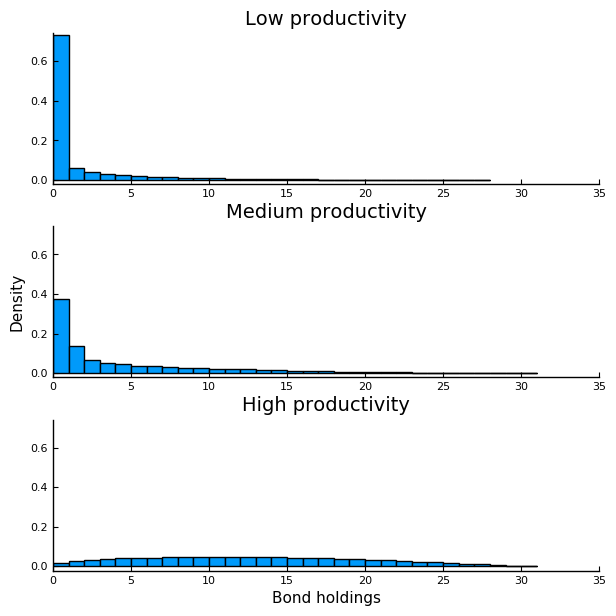

In [74]:
# Force y axis to be the same!
p2 = plot(h1,h2,h3,layout=(3,1),legend = false, fmt= :png, size=(600,600),grid=false,ylim=[0,0.72])
plot!(xlims=(0,35))
savefig("/Users/Anirudh/Desktop/GitHub/PhD_Coursework/ECON611/Replication/TeX/bonds2.pdf")

# Problems with my solution

The above solution is incomplete (i.e. not an actual solution for steady state), because I do not verify that the labor and bond markets clear!

## Labor market clearing

Aggregate labor supply is given by $\bar{L}$ below, which corresponds to equation (12) in MNS. In the steady state, linear production technology and market clearing imply that aggregate labor demand, $\bar{N}$, is given by $\bar{N} =\bar{Y}= \bar{C}$. Accordingly, I should have $\bar{L} = \bar{C}$, but I don't (although I get very close!).

In [16]:
L    = C.^(-γ/ψ).*((Wbar*Z).^(1/ψ)); # Compute lsupply using intratemporal sub condition
zL   = L.*Z;
Lbar = mean(zL)

1.0358220835756748

In [17]:
mean(C)

1.036835602126029

## Bond market clearing

Furthermore, the bond market doesn't clear. MNS calibrate the supply of bonds to 1.4 times annual GDP; i.e. $B = 1.4 \times 4 \times \bar{C}$. I use this calibration, and the government budget constraint (equation (4) in MNS) to compute the steady state level of taxes. However, households' demand for bonds, given by the mean of the bond distribution, does not equal supply (see below).

In [18]:
b_supp = 1.4*4*mean(C)

5.806279371905762

In [19]:
b_dem  = mean(B)

5.949910164697001

## Where I'm at...

I'm not exactly sure how I can enforce labor and bond market clearing in my solution above. For example, since there appears to be excess demand for bonds, I would think that we need a lower interest rate; but the steady state interest rate is calibrated! Similarly, it looks like there's excess demand for labor, which would suggest a lower steady state wage is needed; but, again, $\bar{W}$ is constant!

**UPDATE #1**: CH thinks that the small discrepancies may have something to do with the difference between my (equally spaced) bond grid and MNS's! He suggested that I try the usual approach for adjusting $R$ and $W$ to make markets clear, and iterate until convergence -- this sounds like a cool exercise!!

**UPDATE #2**: I tried the exercise to iterate over $R$ and $W$ so that markets clear. My algorithm gets prices to move in the right direction (i.e. $R$ falls from steady state, reflecting excess bond demand, and $W$ rises, reflecting excess labor demand). For example, after 100 iterations, I get $R \approx 1.003$ and $W \approx 0.91$. But the algorithm doesn't converge. I may be updating the prices incorrectly; or maybe the simulation introduces some small error that I can't overcome?

Nonetheless, I think I have a better understanding of MNS's explanation of their solution method (in their computational appendix). First, note that my attempted solution starts by guessing $\bar D$ and $\bar{\tau}$ and iterating until convergence. However, MNS say we need to start by guessing the entire vector of values in $X$! When this guess is not an equilibrium we need to move the entire vector closer to one that is -- which is where their "auxillary model" comes it. In my attempt, I simply update my guess of $\bar D$ and $\bar{\tau}$, but obviously, this isn't enough.

In summary, my attempted solution resembles the solution for a simple Hugget-Beweley model (in which you start by guessing a steady state interest rate, and iterate to convergence); but MNS's model is more complicated!

In [20]:
minimum(B)

0.0

In [21]:
τ

0.11554784574825283

In [22]:
i

28